## Pre Step 1: Nonlinearity correction model

### Overview

The qCMOS' nonlinear response in the low-count regime can be calibrated using flat-field data of various integration times. The flat-field data will be made available upon request due to its large data volume. We provide the correction model for x-coordinates 1100:1300 (around H-alpha) and the entire y-range as `model_1100_1300.npz` in this directory. Also the global behavior (pixel-averaged) is computed and stored as `global_nonlinearity_model.npz` in this directory.



In [24]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob

# These data will be made available upon request due to their large size.
datadir = '/mnt/datazpool/PL/yjkim/BETACMI_f/1_visPLred_data_reduction/calib_data/flats/mean/'

allims = fits.getdata(datadir+'mean_flats.fits')
exptimes = np.load(datadir+'exptimes.npy')

# had to filter out one of the exposure times (bad frames)
good = np.r_[0:19, 20:22]
ims = allims[good]
exptimes = exptimes[good]

print('Exposure times', exptimes)

# Estimate the linear response (assume the count level of the highest exposure time is in the linear range)
corrected_map = np.array([exptimes[k]/exptimes[-1]* ims[-1] for k in range(len(exptimes))])


Exposure times [ 0.0100008  0.0143856  0.0206928  0.0297648  0.0428184  0.050004
  0.0615888  0.0885888  0.1274328  0.1833048  0.2636712  0.3792744
  0.5455656  0.784764   1.0000008  1.1288448  1.62378    2.3357232
  3.3598224  6.9519312 10.0000008]


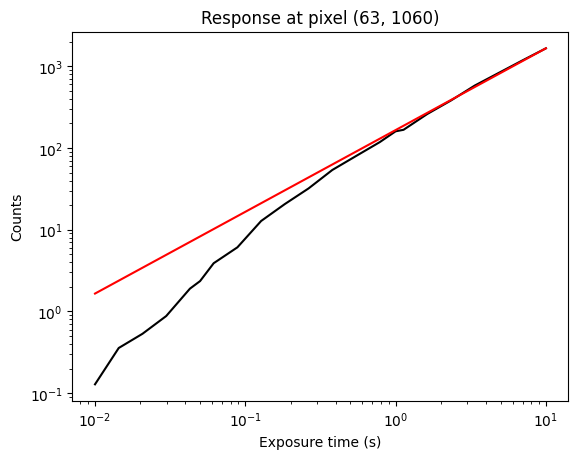

In [60]:
y,x = 63, 1060

plt.loglog(exptimes, ims[:,y,x], label = 'raw', color='black')
plt.loglog(exptimes, corrected_map[:,y,x], label = 'linear model', color='red')
plt.xlabel('Exposure time (s)')
plt.ylabel('Counts')
plt.title('Response at pixel (%d, %d)' % (y,x))
plt.show()

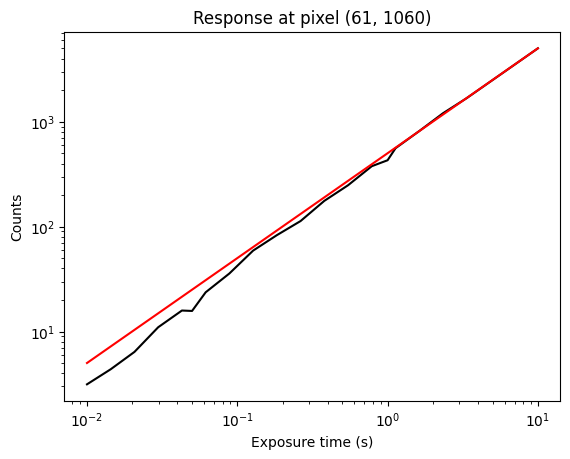

In [61]:
y,x = 61, 1060

plt.loglog(exptimes, ims[:,y,x], label = 'raw', color='black')
plt.loglog(exptimes, corrected_map[:,y,x], label = 'linear model', color='red')
plt.xlabel('Exposure time (s)')
plt.ylabel('Counts')
plt.title('Response at pixel (%d, %d)' % (y,x))
plt.show()

Now we model these curves.

In the `NonlinearityFitter` class I have added two trial functions that seemed to work pretty well. One may modify this class to add more trial functions or set different criteria for adopting model fits.

In [64]:
import PLred.visPLred.preprocess as pp
import importlib

Linear fit loss = 2.46e-01
Trying trial1...
  logloss: Residual=1.09e-02, Success=False, Singular=False
  loss:    Residual=2.26e-01, Success=False, Singular=False
  Accepted trial1 (logloss) with params [ 2.64073610e+01 -2.19744535e-05  1.39007177e+01  1.88692511e+00]
Best fit: trial1 (logloss) with residual 1.09e-02


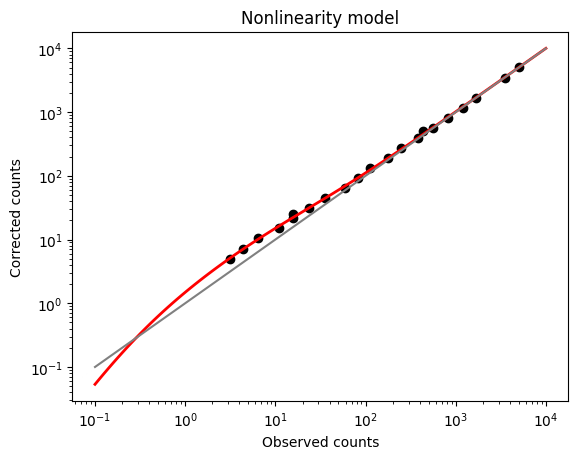

In [62]:
y,x = 61, 1060

fitter = pp.NonlinearityFitter()
fitter.prep_fit(ims[:,y,x], corrected_map[:,y,x])
fitter.fit()
fitter.plot(show=True)

The red curve fits the observed data points (black circles) well! In the model, the observed count levels are stored as well (counts of minimum exposure time and maximum exposure time). If the count of the target image is out of this range, it will not perform the correction and flag the pixel.

We can repeat this for all the pixels. This takes some time, so we will not run this in this notebook. The simple script doing this is as follows:

In [63]:
run_model_generation = False

if run_model_generation:
    xmin = 1100
    xmax = 1300

    model = pp.DetectorNonlinearityModel()
    model.create_model(ims[:,:,xmin:xmax], corrected_map[:,:,xmin:xmax], plot=False,
                    )
    model.save_model(f'model_{xmin}_{xmax}')